In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

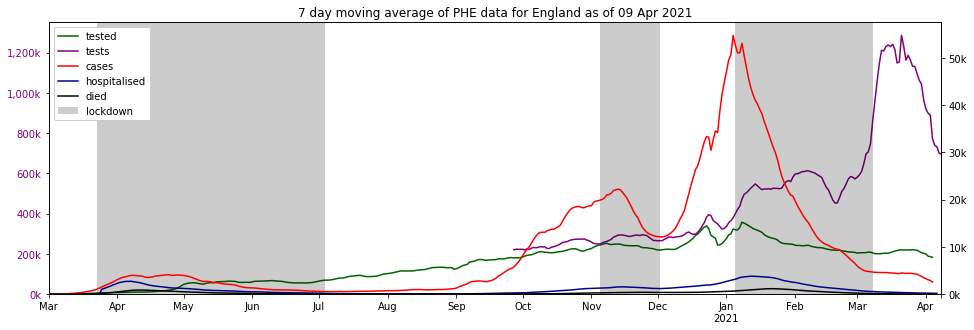

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

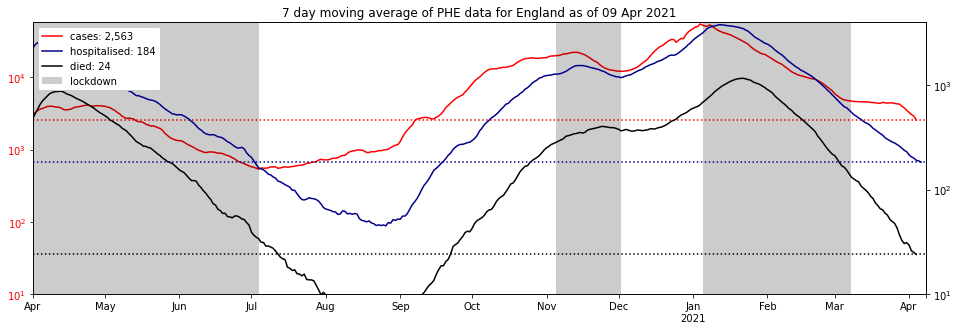

In [3]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

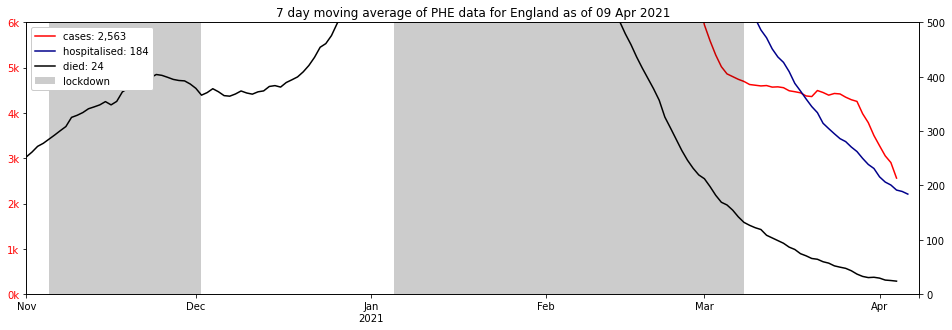

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=6_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=500)

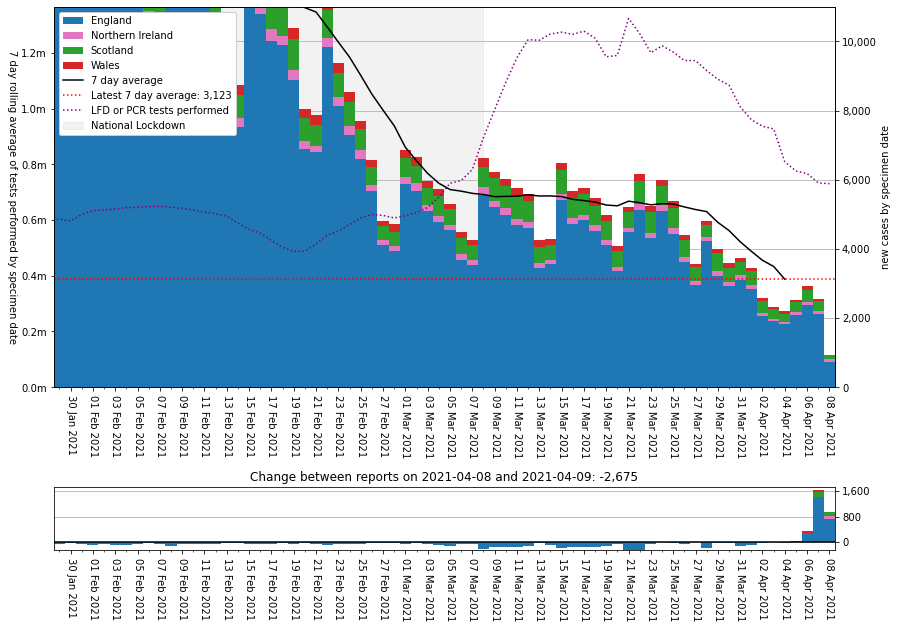

In [5]:
plot_areas(for_date, 'cases_nations', ylim=11_000, earliest='2021-01-29')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,5336230.0,26934662.0,21598432.0,56286961,9.480402,38.371999,52.147600
1,Northern Ireland,N92000002,181814.0,806005.0,624191.0,1893667,9.601160,32.962026,57.436814
2,Scotland,S92000003,524812.0,2625577.0,2100765.0,5463300,9.606135,38.452309,51.941555
3,Wales,W92000004,498318.0,1537122.0,1038804.0,3152879,15.805174,32.947792,51.247035


'partial: 31,903,366 (47.8%), full: 6,541,174'

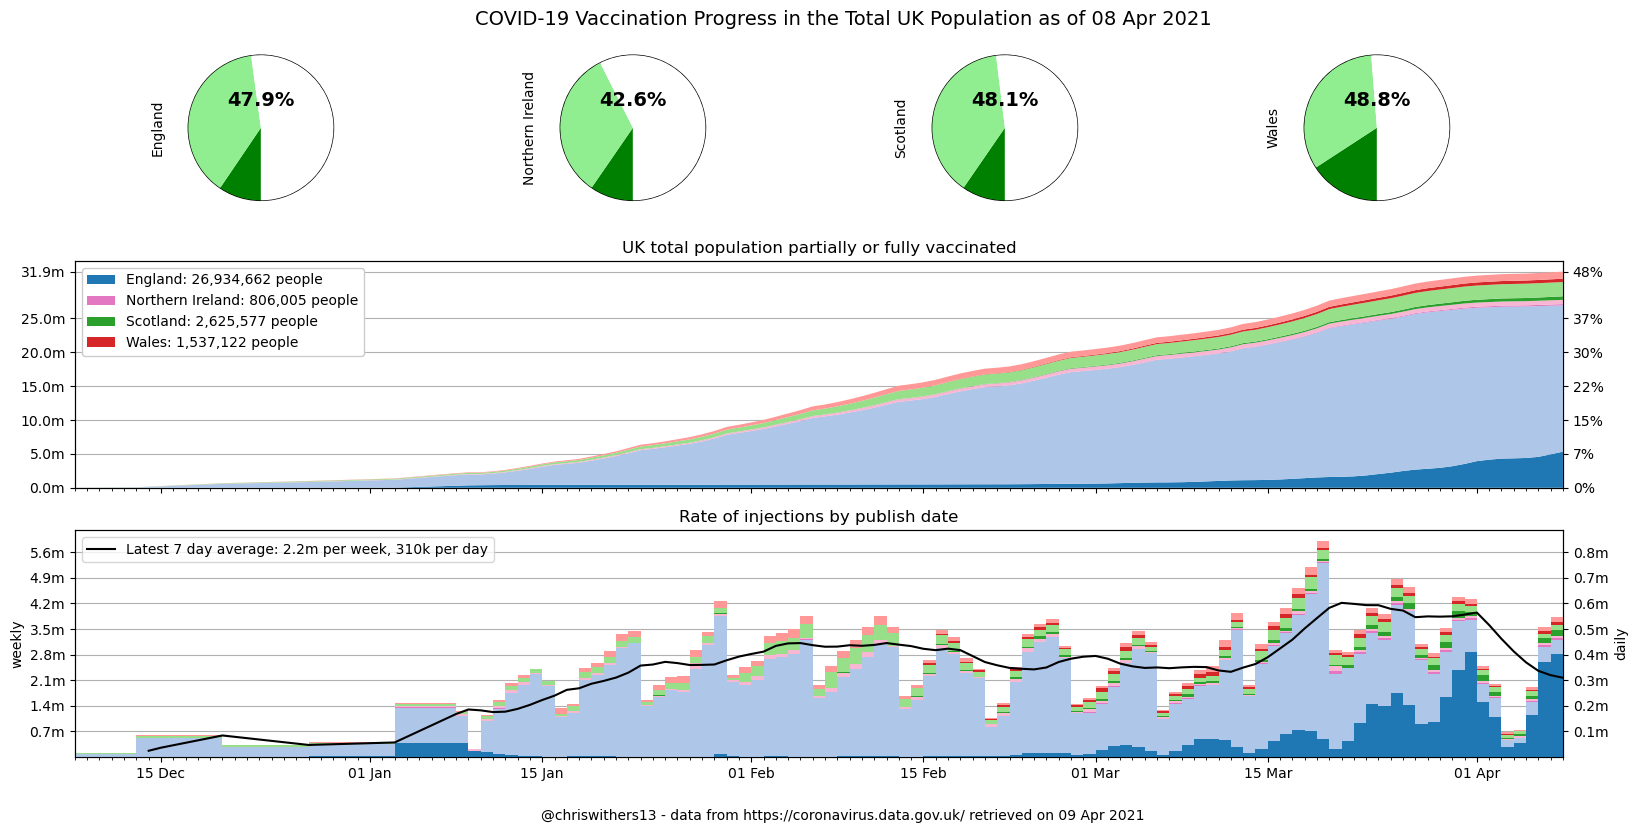

In [6]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [7]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,08 Apr 21,"+55,539","+403,212","+403,212","+26,934,662","+5,336,230","+5,336,230"
Northern Ireland,08 Apr 21,"+6,595","+8,042","+8,042","+806,005","+181,814","+181,814"
Scotland,08 Apr 21,"+16,746","+24,436","+24,436","+2,625,577","+524,812","+524,812"
Wales,08 Apr 21,"+17,362","+13,579","+13,579","+1,537,122","+498,318","+498,318"


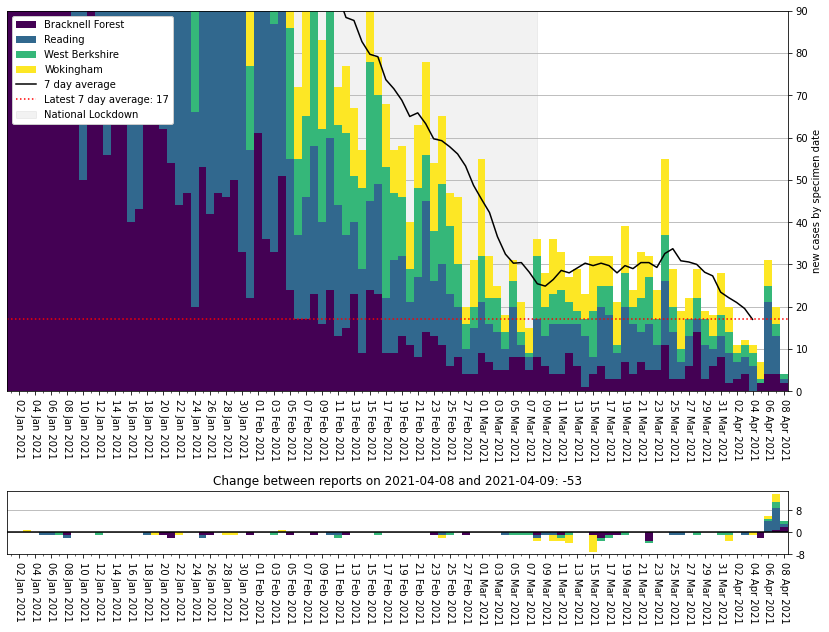

In [8]:
plot_areas(for_date, areas=my_areas, earliest='2021-01-01', ylim=90)

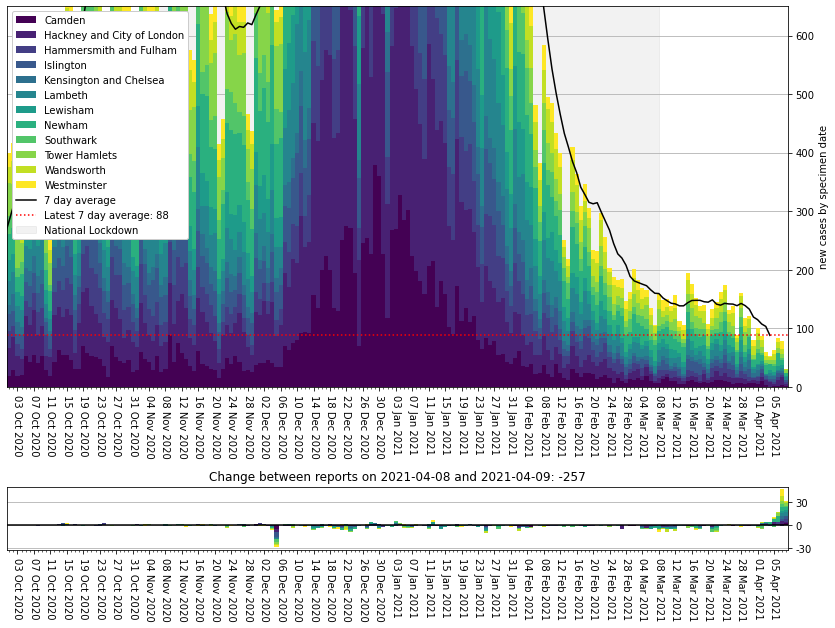

In [9]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [10]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [11]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000005,Clackmannanshire,126.115638,65.0,2021-04-08
E07000174,Mansfield,95.139645,104.0,2021-04-08
E07000150,Corby,91.389958,66.0,2021-04-08
E08000016,Barnsley,84.661314,209.0,2021-04-08
E08000032,Bradford,71.511145,386.0,2021-04-08
E08000036,Wakefield,71.200533,248.0,2021-04-08
E06000016,Leicester,68.600659,243.0,2021-04-08
E06000032,Luton,68.058502,145.0,2021-04-08
E07000136,Boston,66.977327,47.0,2021-04-08


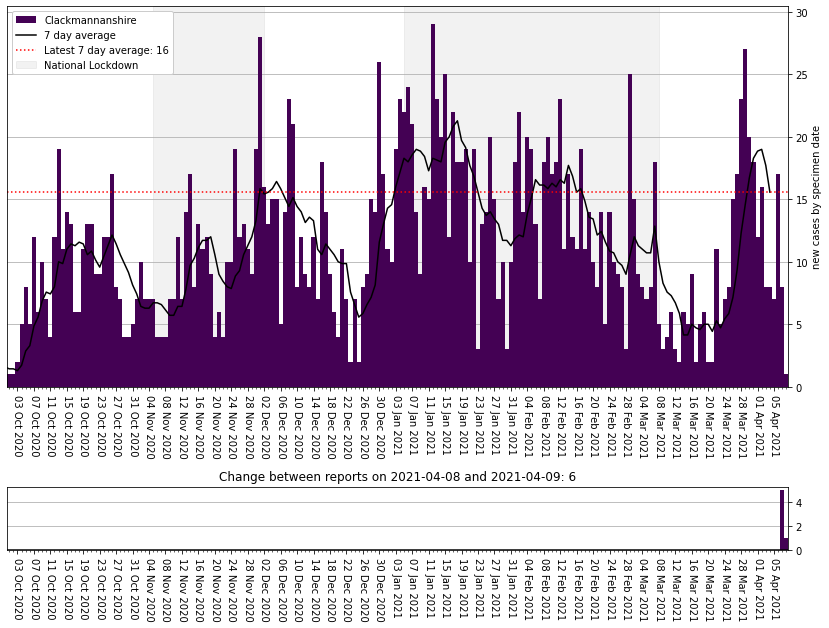

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,57.619156,457.0,2021-04-08
E08000032,Bradford,71.511145,386.0,2021-04-08
S12000049,Glasgow City,60.652009,384.0,2021-04-08
E08000019,Sheffield,59.331148,347.0,2021-04-08
E08000034,Kirklees,61.393356,270.0,2021-04-08
E08000025,Birmingham,22.770744,260.0,2021-04-08
E08000036,Wakefield,71.200533,248.0,2021-04-08
E06000016,Leicester,68.600659,243.0,2021-04-08
E08000003,Manchester,39.612342,219.0,2021-04-08


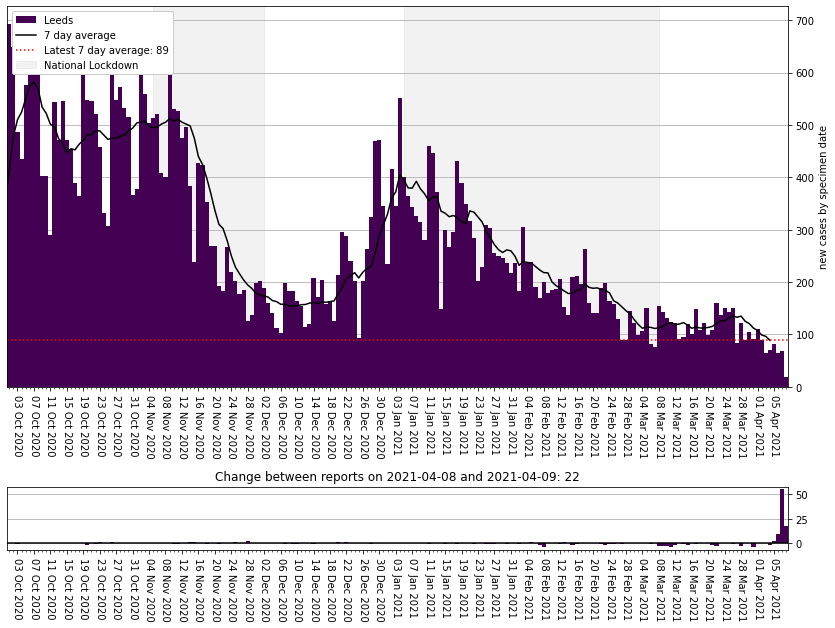

In [14]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [15]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.5
phe_max = 0.18

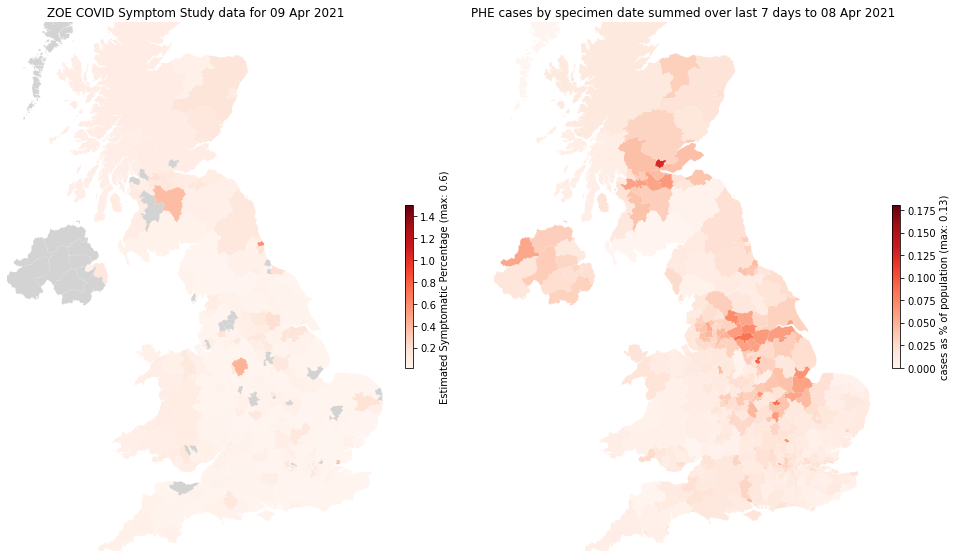

In [16]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [17]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...